# DCM Data Collection Dashboard

In [1]:
import ipywidgets as widgets
import xdcm_dash_functions as f
from matplotlib import rcParams
from xdcm_dash_functions import *
import numpy as np
import skimage.transform as skt

%load_ext autoreload
%autoreload 2
%matplotlib inline

#from brtlearn.shared import config
PIX_DATA_CLASS_DIRT = 0
PIX_DATA_CLASS_WEED = 1
PIX_DATA_CLASS_CROP = 2

## 1) Query all Shasta images from Aletheia Database
(may take several minutes) 

If you get a network error, you may need to reinitialize the VPN connection.


In [2]:
from datetime import datetime

# filter out images that are not NRG (e.g no RGB images), robots that are not DCMS and images with no crop label. 
start = datetime(2020, 3,7)

dcms = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
# , "experiment_id":"representative weed press",
# filter images by robot_name, image type, crop, etc
filters = {"artifacts.kind":'nrg', "crop_name": {"$in": ['SOYBEANS', 'CORN', 'COTTON']}, 'robot_name':{"$in":dcms}}
#filters = {'crop_name':'SOYBEANS', 'has_human_annotation':True}

full_df, elapsed_time = f.get_shasta_data(filters =filters, start=start)
full_df['date_collected'] = pd.to_datetime(full_df['collected_on'].dt.date)
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

Queried 521654 images in 426.72 s.


In [13]:


qdf = full_df.copy()
ofn = 'Senter SE'
eid = 'medium soybeans'
grower = 'Deere'
op = qdf[(qdf['operating_field_name']== ofn)]
gr = qdf[qdf['grower']==grower]
#op.to_csv('op.csv')
labeled = op[op['has_human_annotation']==True]
#print(op.groupby('has_human_annotation').count())
print(f'{len(labeled)} images from this field have been labeled.')
print(f'There were {len(op)} images collected from the {ofn} field.')
print(op.experiment_id.unique())
print(op.grower.unique())
print(op.date_collected.unique())
print(op.robot_name.unique())
print([np.mean(op['latitude']), np.mean(op['longitude'])])

0 images from this field have been labeled.
There were 0 images collected from the Senter SE field.
[]
[]
[]
[]
[nan, nan]


There are 739 unique fields


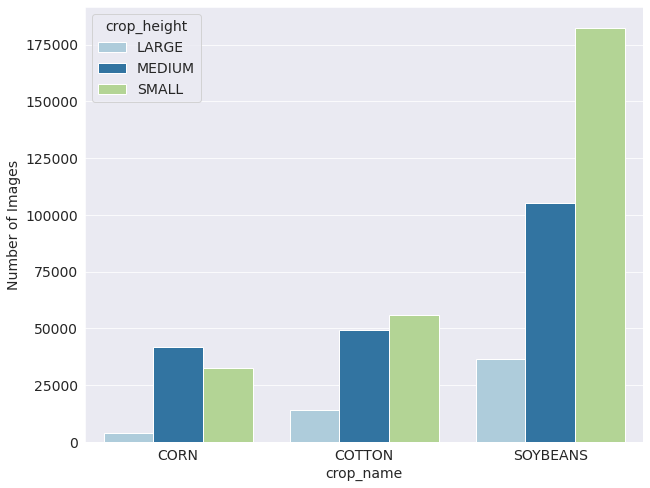

In [3]:
# Graph by Crop Height

qdf=full_df.copy()
rcParams['font.size'] = 14

fields = qdf.groupby(['grower', 'crop_name', 'robot_name', 'operating_field_name'])
print(f'There are {len(fields)} unique fields')

qdf=full_df.copy()
ch=qdf.groupby(['crop_height', 'crop_name']).count().reset_index()

sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
sns.barplot(x='crop_name', y="_id", hue="crop_height", data=ch,palette="Paired")
plt.ylabel("Number of Images")
#plt.savefig('crop_height_distribution.png')
plt.show()

111


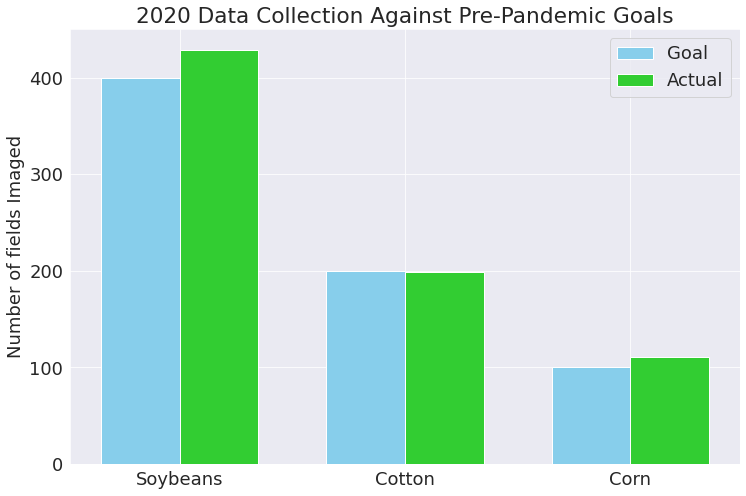

In [7]:
# Graph for Q4 Demo

fields = qdf.groupby(['grower', 'crop_name', 'robot_name', 'operating_field_name']).count().groupby(['crop_name']).count()['_id']
hits = [fields[2], fields[1], fields[0]]
goals = [400, 200, 100]
rcParams['font.size'] = 18

sns.set_style('darkgrid')

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

plt.figure(figsize=(12,8))
ax=plt.subplot()
rects1 = ax.bar(ind, goals, width, color='skyblue')
rects2 = ax.bar(ind+width, hits, width, color='limegreen')

ax.set_ylabel('Number of fields Imaged')
ax.set_title('2020 Data Collection Against Pre-Pandemic Goals')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Soybeans', 'Cotton', 'Corn'] )
ax.legend( (rects1[0], rects2[0]), ('Goal', 'Actual') )
#plt.savefig('field_imaging_goals.png', dpi=80)
plt.show()


In [8]:
# Search for images from specific date, field or robot_name

qdf = full_df.copy()

qdf = qdf[(qdf['crop_name']=='SOYBEANS')&(qdf['date_collected']=='2020-06-22')&(qdf['robot_name']=='DCM-OTTER')]
print(qdf.operating_field_name.unique())

['East of TRC' '22' '23' 'Northeast of TRC']


### 1.1) Create list of image IDs matching specific criteria

Useful for coordinating labeling, communicating file lists, etc.

In [65]:
##### Also Runs an Aletheia Query but is Distinct From Above Cell

from datetime import datetime

# filter images by robot_name, image type, crop, etc
filters = {"robot_name":"SHASTA-FB-BRADLEY"}
# Filter by date
start = datetime(2020, 3,7)

atm_df, elapsed_time = f.get_shasta_data(filters=filters, start=start)
atm_df['date_collected'] = pd.to_datetime(atm_df['collected_on'].dt.date)
print(f"Queried {len(atm_df)} images in {elapsed_time:.2f} s.")
#dates = atm_df[atm_df['date_collected'] =='2020-06-07']
#dates.head()

Queried 65223 images in 72.85 s.


### 1.2) Examine The Newest Fields Added

List the Newest Fields Available After a Certain Data

In [40]:
# Examine the newest fields imaged after a specific date 

all_fields = full_df.copy()

# Define 'Fields' as having a unique grower, farm, name and crop.
total_fields = all_fields.groupby(['grower','farm','operating_field_name']).count()

# Set the start date for 'new' fields
start_date = '2020-07-14'

# Select all new fields since the start date
new_fields = (all_fields[all_fields['date_collected'] >= start_date]).groupby(['grower','experiment_id','operating_field_name', 'crop_name', 'crop_height']).count()
#new_fields.to_csv('newest_fields.csv')
print(f'There are {len(total_fields)} total fields in the database for this season.')
print(f'There are {len(new_fields)} new fields added since {start_date}')
new_fields['_id']

There are 732 total fields in the database for this season.
There are 28 new fields added since 2020-07-14


grower         experiment_id              operating_field_name       crop_name  crop_height
Eddie Smith    Large cotton               2752 Newman Southwest      COTTON     LARGE           606
                                          2752 West                  COTTON     LARGE           419
                                          2774 Parrish               COTTON     LARGE           487
                                          2774 Parrish West          COTTON     LARGE           405
                                          2774 Parrish West Highway  COTTON     LARGE           362
                                          2774 Parrish south         COTTON     LARGE           423
               Large ctton                2774 Parrish West Highway  COTTON     LARGE            41
               large cotton               865 Bowman                 COTTON     MEDIUM          460
               medium cotton              2773 Assiter #1            COTTON     MEDIUM          426
        

In [49]:
# Look for fields with specific metadata properties

cc = 'OVERCAST'
sc = 'DARK'

qdf = full_df.copy()
qdf=qdf[qdf['has_human_annotation']==True]
qdf =qdf[qdf['crop_name']=='SOYBEANS']
qdf = qdf[(qdf['cloud_cover']==cc) & (qdf['soil_color']==sc)]
qdf = qdf.groupby(['soil_color','cloud_cover','operating_field_name']).count().reset_index()
qdf

,soil_color,cloud_cover,operating_field_name,_id,is_deleted,collected_on,gnss,annotations,artifacts,has_human_annotation,...,robot_name,artifacts_content_hash,notes,camera_height,camera_ppi,gps_quality,isp_version,latitude,longitude,date_collected
0,DARK,OVERCAST,121,400,400,400,400,400,400,400,...,400,400,198,400,400,400,400,400,400,400
1,DARK,OVERCAST,Franzen,10,10,10,10,10,10,10,...,10,10,3,10,10,10,10,10,10,10
2,DARK,OVERCAST,Kenyon east,245,245,245,245,245,245,245,...,245,245,201,245,245,245,245,245,245,245
3,DARK,OVERCAST,Sinclair,157,157,157,157,157,157,157,...,157,157,69,157,157,157,157,157,157,157
4,DARK,OVERCAST,across from shop,250,250,250,250,250,250,250,...,250,250,0,250,250,250,250,250,250,250
5,DARK,OVERCAST,north of 94th,214,214,214,214,214,214,214,...,214,214,214,214,214,214,214,214,214,214


### 1.3) Inspect an Individual Field and its Properties

### 1.5) Number of fields Imaged Over Time

Visualizing the Number of Fields Imaged Over Time, Aggregated by Week in 2020

there are 726 total fields so far this year
18
18


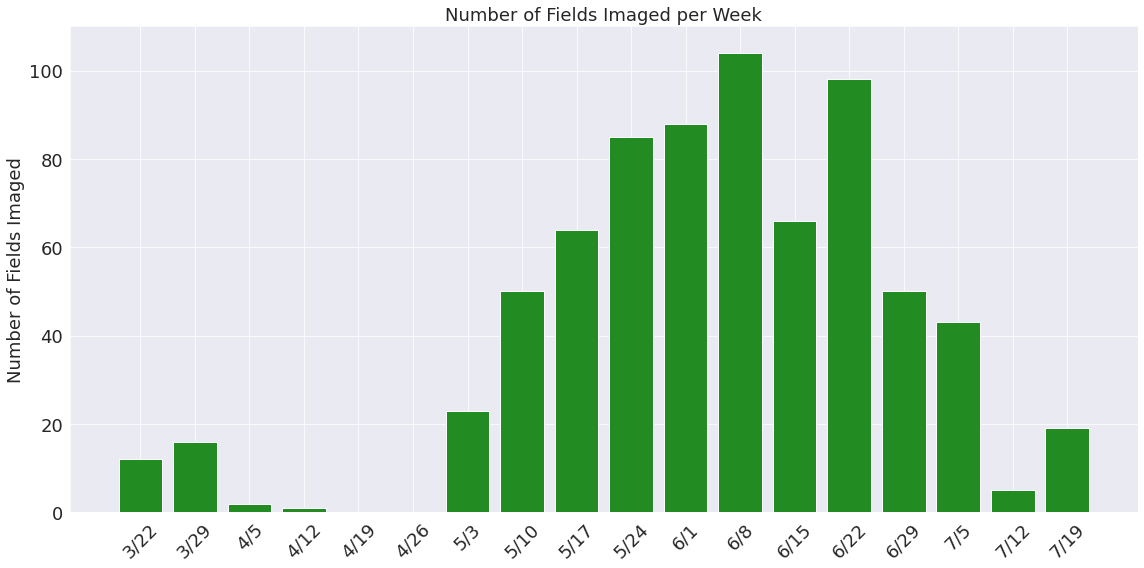

In [15]:
sns.set_style('darkgrid')
qdf = full_df.copy()
qdf['week'] = qdf['collected_on'].dt.week
weeks = qdf.groupby(['week','operating_field_name', 'crop_name']).count().groupby('week').count()['_id']

weeks.loc[17]=0
weeks.loc[18]=0
weeks= weeks.sort_index(axis=0)
print(f'there are {sum(weeks)} total fields so far this year')
index_dates = ['3/22', '3/29', '4/5', '4/12', '4/19', '4/26', '5/3', '5/10', '5/17', '5/24', '6/1', '6/8', '6/15','6/22', '6/29', '7/5', '7/12', '7/19']
print(len(index_dates))
print(len(weeks))
plt.figure(figsize=(16,8))
plt.bar(x=index_dates, height=weeks, width=0.8, color='forestgreen')
plt.ylim(0,110)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.ylabel('Number of Fields Imaged', fontsize=18)
plt.title('Number of Fields Imaged per Week', fontsize=18)
plt.tight_layout()
plt.savefig('data_collection_over_time.png', dpi=100)
plt.show()

### 1.6)  Annotation Progress

How many images have been annotated to date from this data

crop_name  has_human_annotation
CORN       False                    72444
           True                      6161
COTTON     False                    70488
           True                     33512
SOYBEANS   False                   283367
           True                     38671
Name: farm, dtype: int64


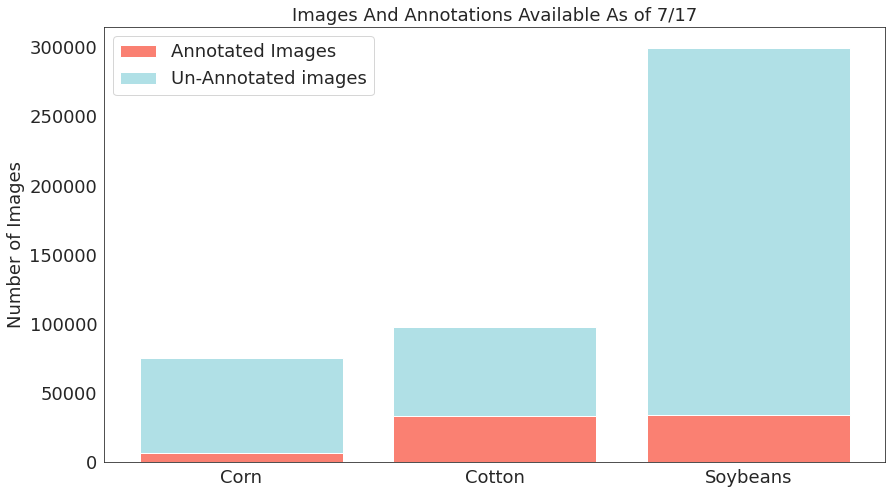

In [17]:
# Needs work so numbers don't have to be set manually
qdf=full_df.copy()
qdf = qdf.groupby(['crop_name', 'has_human_annotation']).count()
print(qdf['farm'])

crops = ['Corn', 'Cotton', 'Soybeans'] 
annotated = [6161, 33479, 33769]
not_annotated = [69173, 63804, 265836]
sns.set_style('white')

plt.figure(figsize=(14,8))
plt.title('Images And Annotations Available As of 7/17', fontsize=18)
plt.bar(x=crops, height=annotated, color='salmon', edgecolor='white', width=0.8)
plt.bar(x=crops, height=not_annotated,bottom=annotated, color='powderblue', edgecolor='white', width=0.8)
plt.legend(['Annotated Images', 'Un-Annotated images'], fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Number of Images', fontsize=18)
plt.xticks(fontsize=18)
#plt.savefig('annotation_progress.png', dpi=100)
plt.show()

## Examine Individual Attributes of Metadata



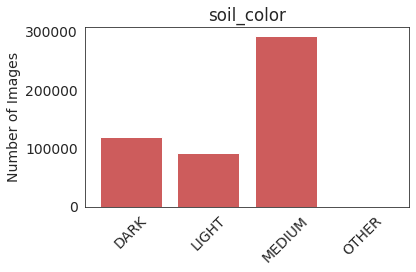

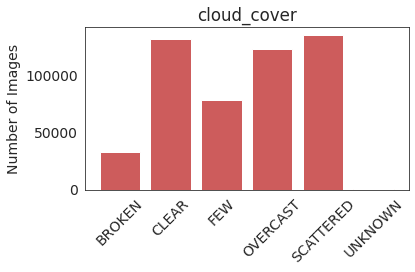

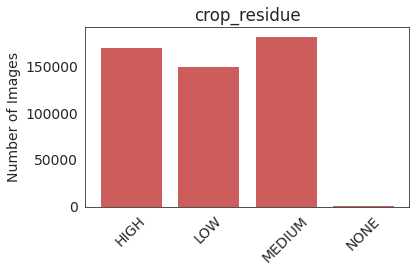

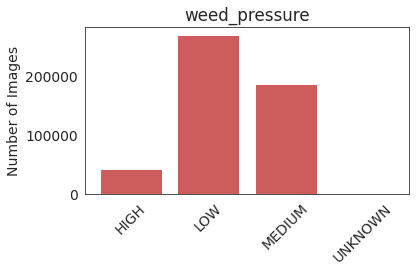

In [18]:
qdf = full_df.copy()
data_vars = ['soil_color', 'cloud_cover', 'crop_residue', 'weed_pressure']
#subset = qdf.groupby(var_to_sort).count()['_id']

for v in data_vars:
    subset = qdf.groupby(v).count()['_id']
    plt.bar(subset.index, height=subset, color='indianred')
    plt.title(v)
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(v+'.png')
    plt.show()

### 1.1) Number of Images by Crop and Number of Fields by Crop

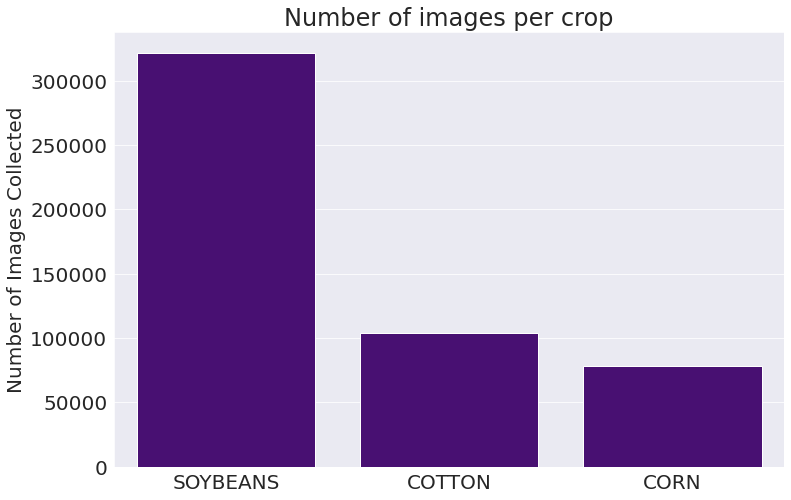

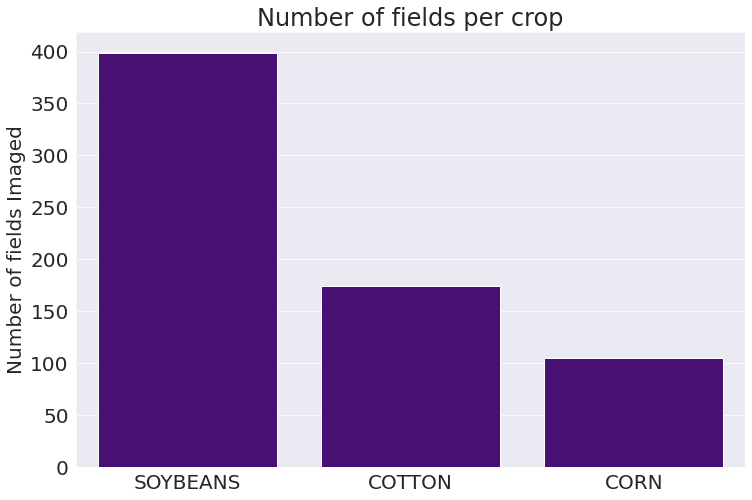

In [8]:
plt.figure(figsize=(12,8))
rcParams['font.size'] = 20
f.plot_num_images_by_crop(full_df)
plt.ylabel('Number of Images Collected')
plt.savefig('crops.png')

plt.figure(figsize=(12,8))
rcParams['font.size'] = 20
f.plot_num_fields_by_crop(full_df)
plt.ylabel('Number of fields Imaged')
plt.savefig('fields_by_crop.png')

### 1.3) Table of Regional Targets by Crop

See how well we are tracking our regional field # targets. For more details see the chart in Section 4.1.

In [9]:
tdf = f.get_region_level_progress(full_df)
tdf.loc[:, [c for c in tdf.columns if c != 'Region']] *= 100
tdf = tdf.loc[:, ['Region', 'soybeans_fields', 'cotton_fields', 'corn_fields']]
pd.options.display.float_format = '{:,.2f}'.format
tdf.rename(columns={'Region': 'Region', 'soybeans_fields': 'Soy Field %', 'cotton_fields': 'Cotton Field %', 'corn_fields': 'Corn Field %'})

,Region,Soy Field %,Cotton Field %,Corn Field %
0,Delta,135.00,107.14,75.00
1,Midwest,110.88,nan,112.50
2,North,84.71,inf,90.91
3,Southcentral,20.00,82.26,600.00


## 2) Sample and Visualize Images

In [ ]:
crop_widget = widgets.Dropdown(options=full_df["crop_name"].unique(), description='Crop Name:', disabled=False)
crop_widget

In [15]:
# Filter images by selected crop and find datapoints with gps coordinates.
crop_name = 'SOYBEANS'

df = full_df[full_df.crop_name == crop_name].reset_index(drop=True)
gdf = f.to_geopandas(df)
print(f"{len(gdf)} {crop_name.lower()} points have GPS ({100 * len(gdf) / len(df):.2f}% of total)")

102217 soybeans points have GPS (100.00% of total)


### 2.1) Sample and Visualize Images

Type an integer into `n=` below to visualize false-color NRG images and the calculated NDVI masks.
Run again to shuffle images.

0: primary datapoint id: 5ebc900df17b614dc047ca2b, group: da117ba4-5532-4e06-b40e-28673244117f
1: primary datapoint id: 5ebc7930c69540255b9e6750, group: 0830cb9b-5edf-422a-9190-6c8d635a3eaa
2: primary datapoint id: 5ebc658b40522a75b63685d0, group: dbef55fe-f238-4fc5-a206-99407cb2fba5
3: primary datapoint id: 5ebc96036328a606ca4b0384, group: 1e83d56f-d6c7-4b99-a234-060a628e227a
4: primary datapoint id: 5ebc75e2a77c3c79d5c438ee, group: f09cc8f6-ae4e-4b69-a21b-43cf27fa0a89


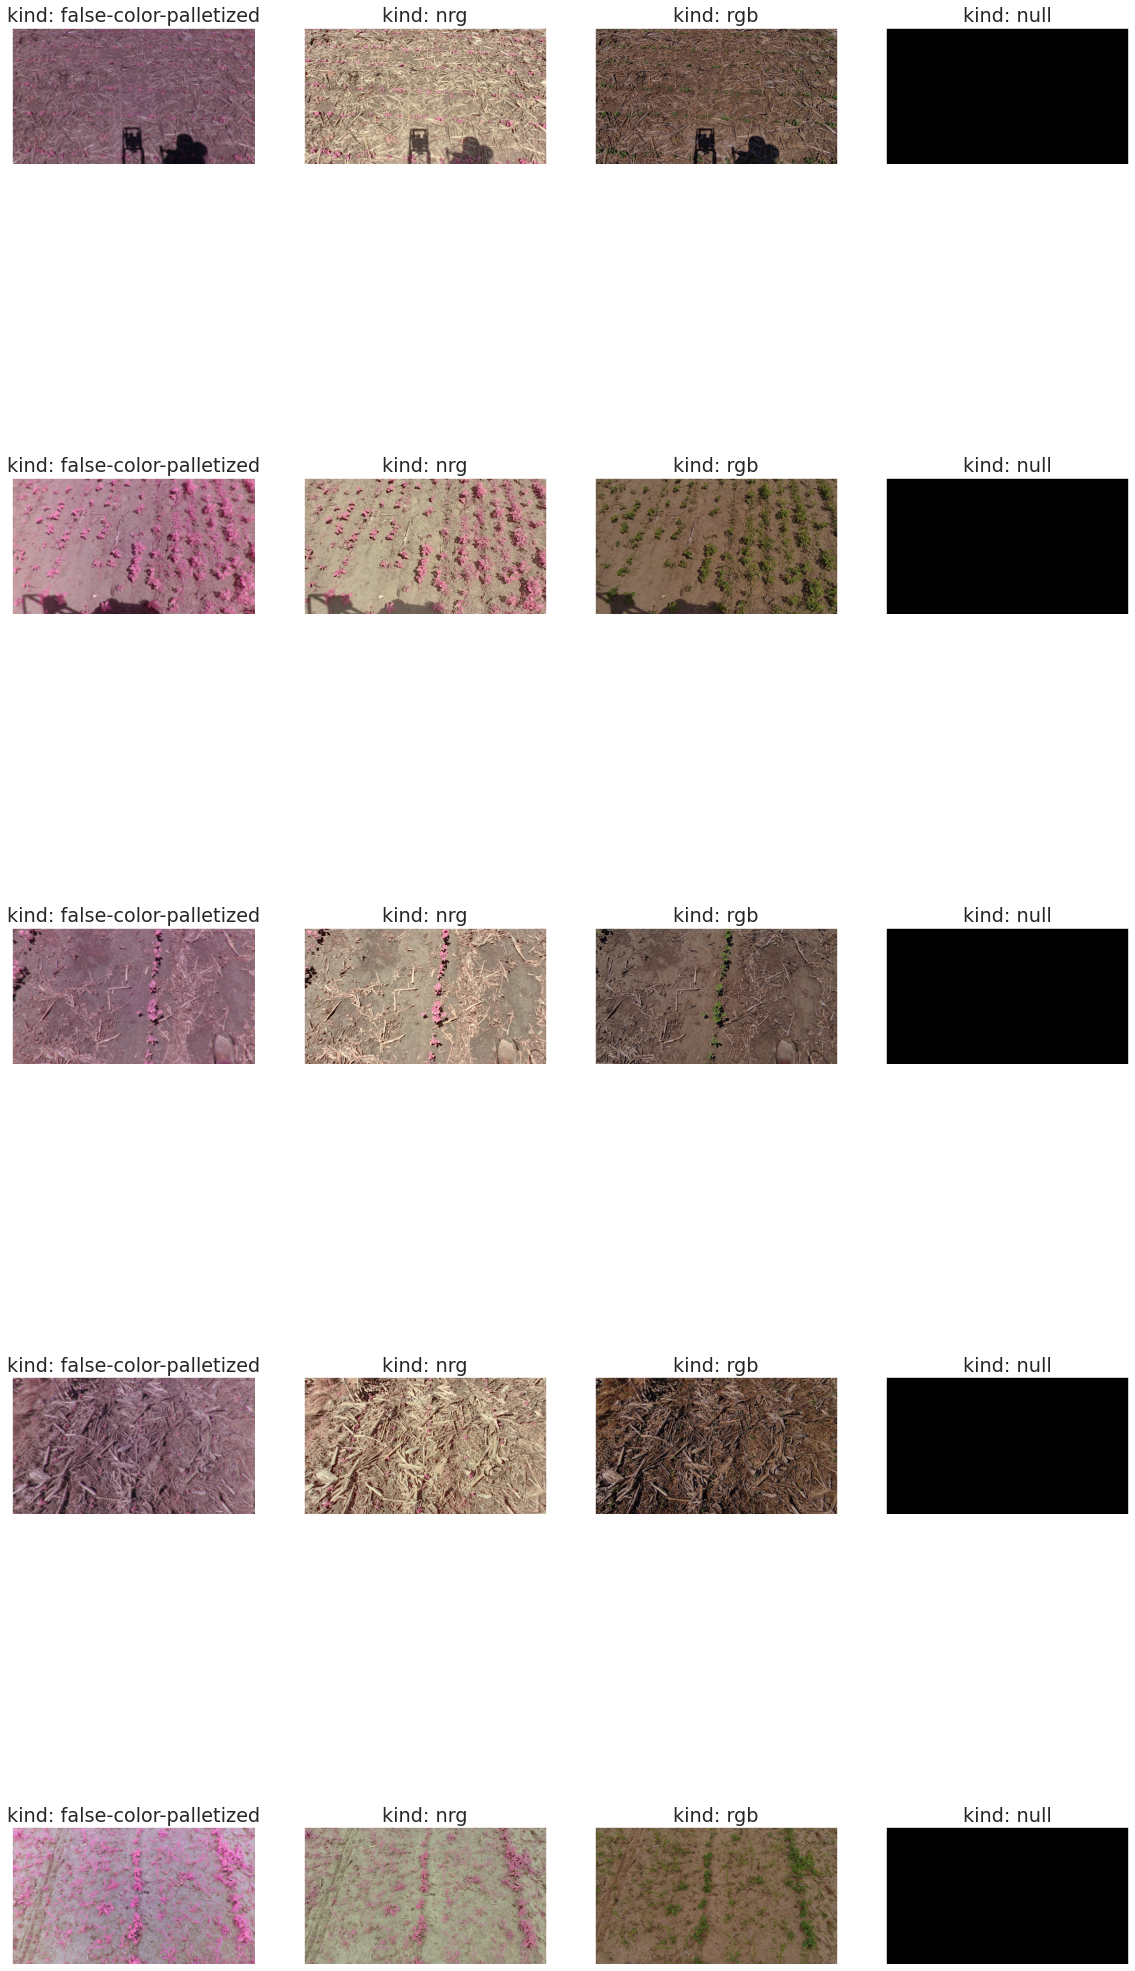

In [96]:
f.sample_and_display_images(df, n=5)

## Available Metadata fields

Metadata that should be available for next season: https://bluerivertechnology.atlassian.net/wiki/spaces/WVSD/pages/700678370/Shasta+System+Metadata+Definition

In [193]:
print(full_df.columns)
weed_pressure = full_df.groupby(['weed_pressure']).count()['_id']
weed_pressure

Index(['_id', 'is_deleted', 'collected_on', 'gnss', 'annotations', 'artifacts',
       'has_human_annotation', 'uuid', 'artifacts_content_hash',
       'angle_to_row', 'camera_exposure_algo', 'camera_exposure_time',
       'camera_focal_length', 'camera_fstop', 'camera_gain', 'camera_height',
       'camera_manufacturer', 'camera_ppi', 'camera_revision',
       'camera_sensor_name', 'camera_sensor_type', 'camera_serial',
       'cloud_cover', 'crop_damage', 'crop_health', 'crop_height', 'crop_name',
       'crop_residue', 'experiment_id', 'farm', 'furrow_depth_inches',
       'gps_course', 'gps_quality', 'gps_speed', 'group_id', 'grower',
       'icp_version', 'isp_version', 'latitude', 'longitude',
       'operating_field_name', 'operator_name', 'project_name',
       'raw_bit_depth', 'robot_name', 'row_spacing', 'soil_color',
       'tillage_practice', 'type', 'weed_pressure', 'weeds', 'notes',
       'date_collected'],
      dtype='object')


weed_pressure
HIGH        4874
LOW        41642
MEDIUM     30195
UNKNOWN     1674
Name: _id, dtype: int64

## 3) Data Collection per week.

How many images have we collected per week and how many have we collected in total. Dates given by first day of week.

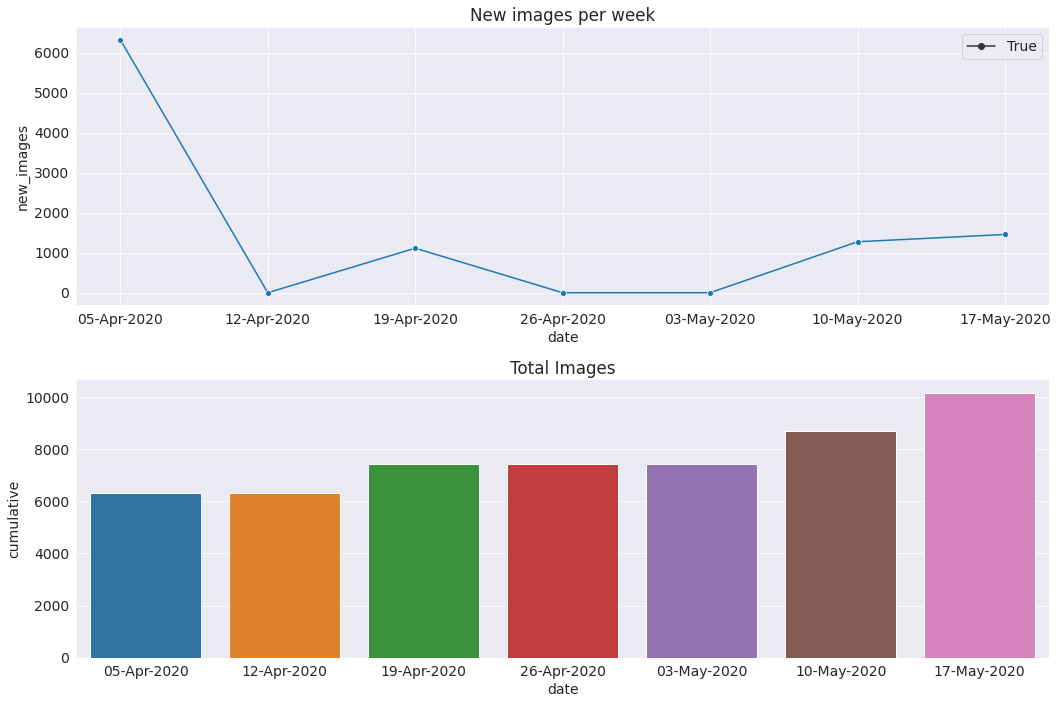

In [253]:
f.plot_data_collection_by_week(df)

## 4) Data Collection by Geographical Area

Heatmap of counties and states by numbers of collected images in that state/county.

USDA crop production map for reference:

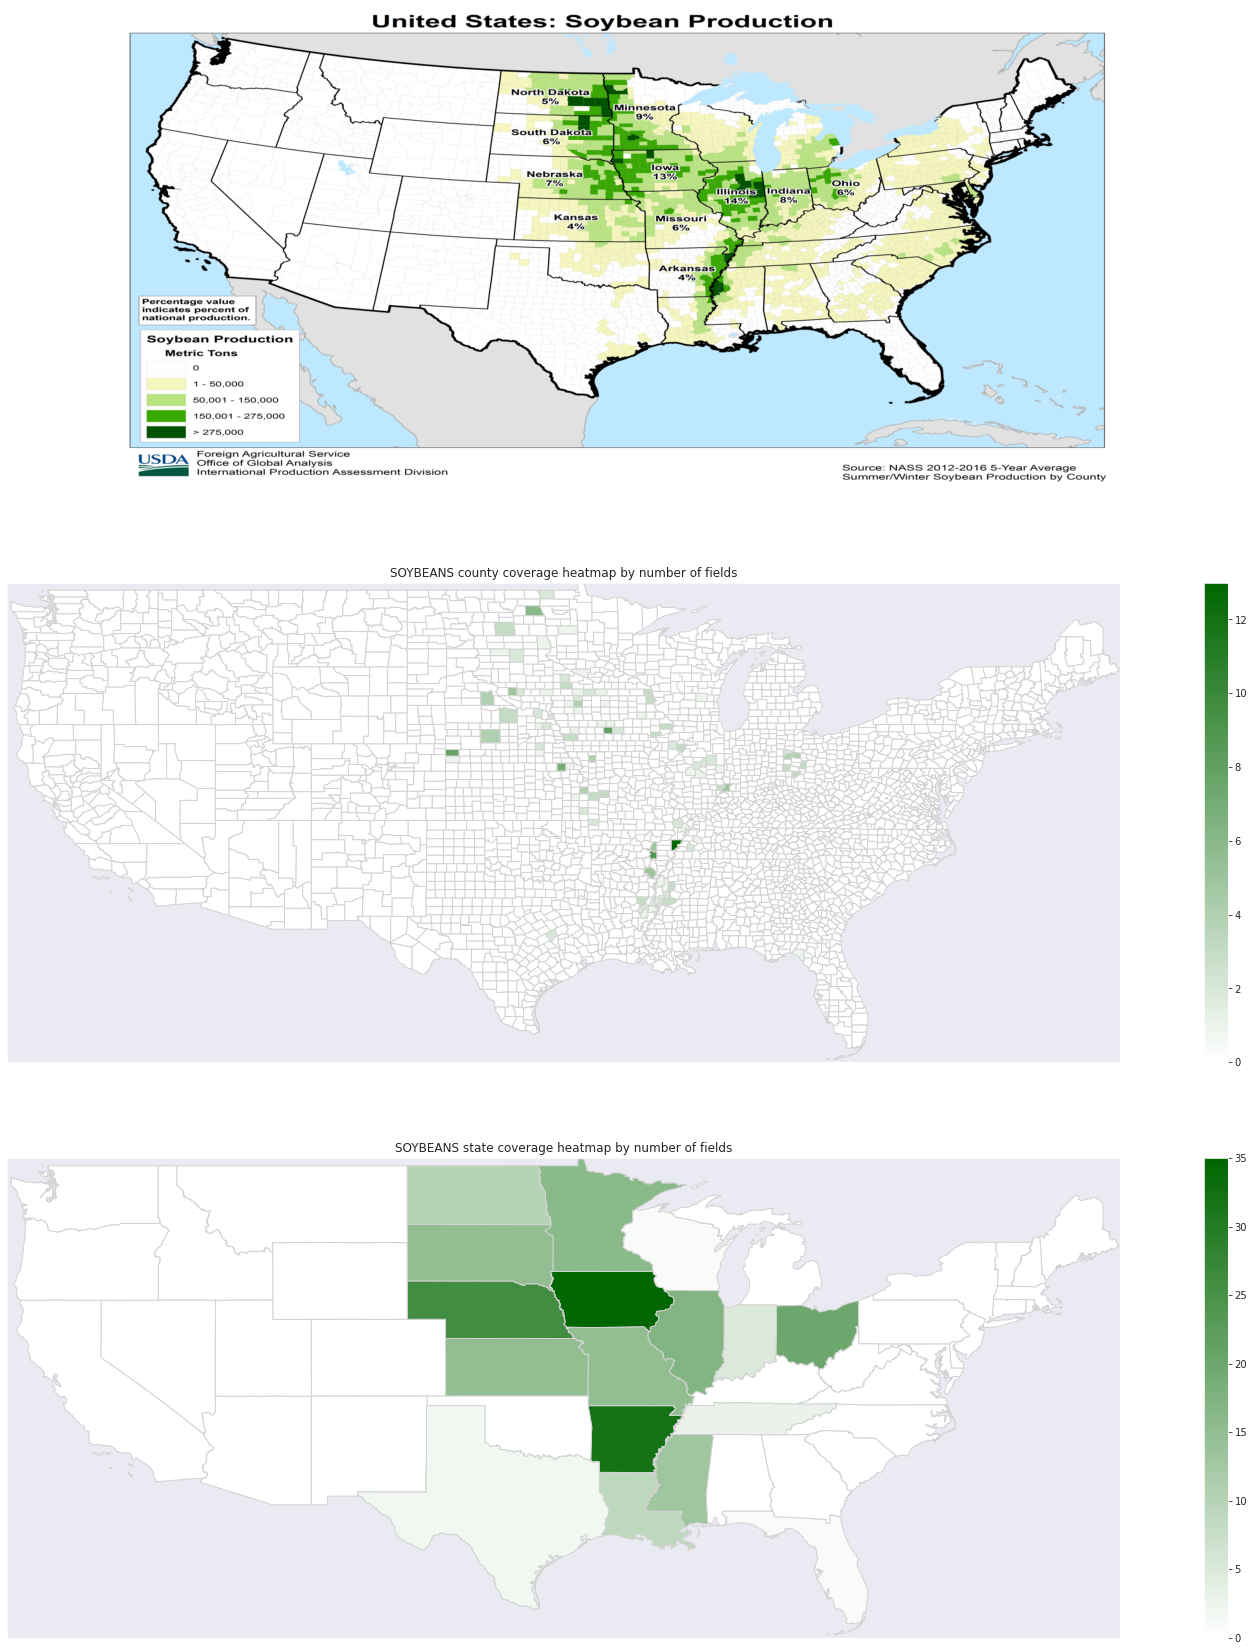

In [4]:
crop_name = 'SOYBEANS'
f.plot_crop_heatmap(gdf, crop_name, count_images=False)
plt.savefig('soy_map.png')

### 4.1) State Field and Grower Targets 
The table below shows the 2020 target number of fields and growers per state for the chosen crop. It also shows how well many fields and growers we have per state.

In [10]:
# Filter images by selected crop and find datapoints with gps coordinates.
crop_name = 'SOYBEANS'

df = full_df[full_df.crop_name == crop_name].reset_index(drop=True)
gdf = f.to_geopandas(df)
print(f"{len(gdf)} {crop_name.lower()} points have GPS ({100 * len(gdf) / len(df):.2f}% of total)")

f.get_state_target_dataframe(gdf, crop_name='SOYBEANS')

321897 soybeans points have GPS (100.00% of total)


,Region,State,soybeans_field_count,soybeans_field_target,soybeans_grower_count,soybeans_grower_target
0,Midwest,Iowa,53,35,23,12
1,North,Minnesota,22,35,12,10
2,Midwest,Indiana,11,32,4,11
3,Midwest,Illinois,47,28,21,11
4,Midwest,Nebraska,30,27,10,9
5,Delta,Missouri,32,25,10,9
6,Midwest,Ohio,22,25,8,8
7,North,North Dakota,28,25,7,8
8,North,South Dakota,22,25,7,8
9,Delta,Arkansas,38,20,8,8


85351 soybeans points have GPS (100.00% of total)


,Region,State,soybeans_field_count,soybeans_field_target,soybeans_grower_count,soybeans_grower_target
0,Midwest,Iowa,33,35,17,12
1,North,Minnesota,7,35,6,10
2,Midwest,Indiana,5,32,2,11
3,Midwest,Illinois,17,28,9,11
4,Midwest,Nebraska,26,27,10,9
5,Delta,Missouri,1,25,1,9
6,Midwest,Ohio,19,25,8,8
7,North,North Dakota,0,25,0,8
8,North,South Dakota,4,25,3,8
9,Delta,Arkansas,32,20,7,8


In [38]:
targets_df = pd.read_csv('data/StateDataCollectionTargets_revised.csv')
print(sum(targets_df['corn_field_target']))
targets_df

81


,Region,State,soybeans_field_target,cotton_field_target,corn_field_target,soybeans_grower_target,cotton_grower_target,corn_grower_target,growers_per_state
0,Midwest,Iowa,35,0,11,12,0,4,12
1,North,Minnesota,35,0,9,10,0,3,10
2,Midwest,Indiana,32,0,11,11,0,4,11
3,Midwest,Illinois,28,0,11,11,0,4,11
4,Midwest,Nebraska,27,0,9,9,0,3,9
5,Delta,Missouri,25,12,5,9,4,2,9
6,Midwest,Ohio,25,0,6,8,0,2,8
7,North,North Dakota,25,0,6,8,0,2,8
8,North,South Dakota,25,0,7,8,0,3,8
9,Delta,Arkansas,20,18,3,8,0,2,8


## 5) Crop Type Visualizations
Requirements: https://docs.google.com/presentation/d/1f7aCFRoO2FbVuBBCVwwlQg2lb_jJL5fTs0kgkMv9Mf8/edit?usp=sharing

In [129]:
visualization_type_widget = widgets.Dropdown(
    options=['Crop Status', 'Cultural Practices', 'Weeds'], value='Weeds', description='Visualize:', disabled=False)
visualization_type_widget

Dropdown(description='Visualize:', index=2, options=('Crop Status', 'Cultural Practices', 'Weeds'), value='Wee…

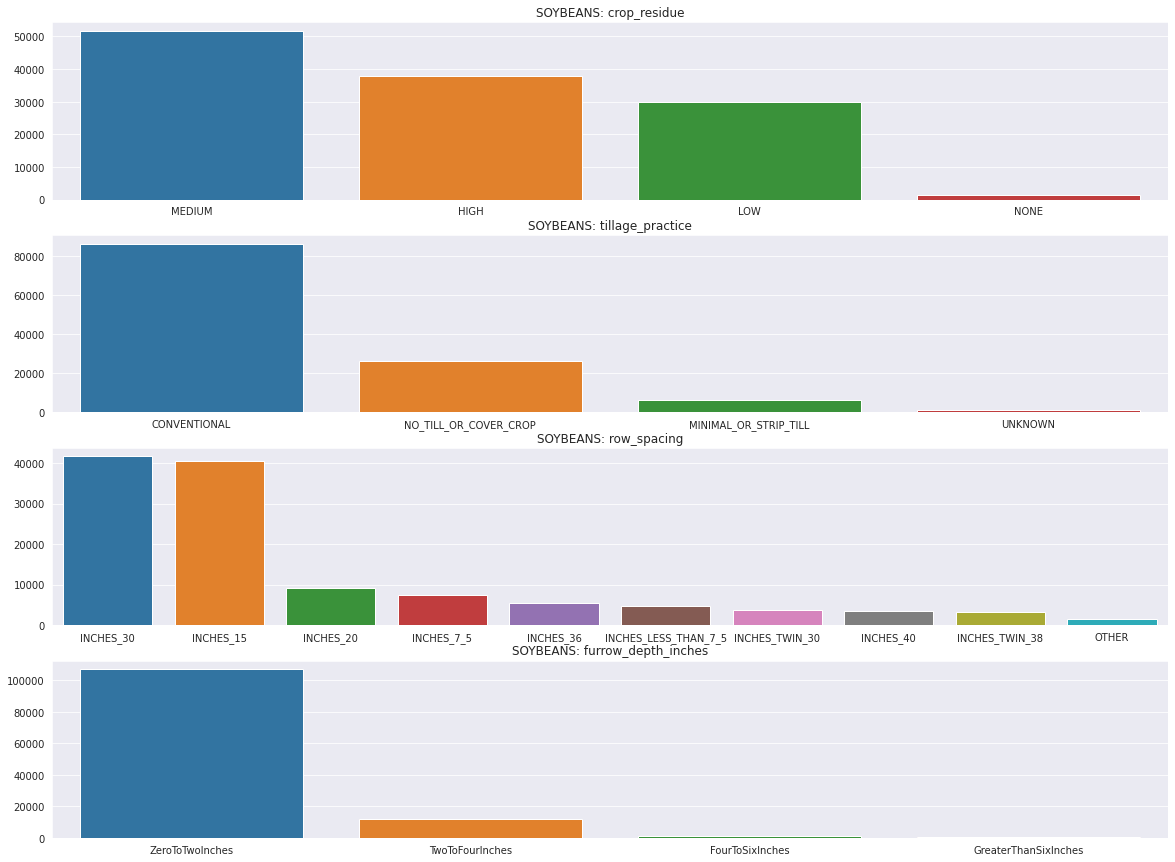

In [6]:
f.plot_crop_visualization(df, crop_name='SOYBEANS', vis_name='Cultural Practices')
plt.savefig('soy_graphs.png')

## 6) Data Collection Against Field Gradient Goals